# Création d'un dataset d'ordre de lecture sur PubLayNet

In [1]:
# !pip install Unidecode
# !pip install fuzzysearch

# !pip install elementpath
# !pip install lxml 
# !pip install graphviz
# !pip install pydotplus

In [2]:
!ls ../../../edspdf-train/data/publaynet/

dev.json			test	       train	       xmls
oa_file_list.ARTgjjvC.csv.part	test_urls.txt  train_urls.txt  xmls-bis


In [5]:
import sys
sys.path.append('../')
import os
from pathlib import Path
import json
from sort_xml import *
import numpy as np
import pickle as pk

from edspdf import Pipeline
from edspdf.structures import Box, PDFDoc


base_dir = '../../../edspdf-train/data/publaynet/'

%load_ext autoreload
%autoreload 2

sys.executable

'/export/home/smbaye/edspdf-train/.venv/bin/python'

### Load pdf and xml names and info

In [4]:
xmls_dir = base_dir + 'test/'
dev_path = base_dir + 'dev.json'

with open(Path(dev_path)) as f:
    samples = json.load(f)

# load xml files
xmls_names = {} # {pmc = {xml_fname, pdf_fname}}
for root, directories, files in os.walk(xmls_dir):
    for pmc in directories:
        fdir = xmls_dir + pmc
        for root2, directories2, files2 in os.walk(fdir):
            xml_fname = None
            pdfs_fnames = []
            for file in files2:
                if file.split('.')[-1] == 'nxml':
                    xml_fname = file
                if file.split('.')[-1] == 'pdf':
                    pdfs_fnames.append(file)

            lenghts = [len(pf) for pf in pdfs_fnames]
            # if len(lenghts) == 0:
            #   print(f'fdir ==> {fdir}')

            i_min = np.argmin(lenghts)
            xmls_names[pmc] = {'xml' :xml_fname, 'pdf': pdfs_fnames[i_min], 'page_num': None}
    break
# end load xml files
    
    
for image in samples['images']:
    pmc = image['file_name'].split('_')[0]
    if pmc in xmls_names:
        page_num = int(image['file_name'].split('_')[1].split('.')[0])
        xmls_names[pmc]['page_num'] = page_num


In [5]:
print(f'Nb pmc {len(xmls_names)}')
for k,v in xmls_names.items():
    print(f'k: {k} -> v: {v}')
    break

Nb pmc 200
k: PMC3142684 -> v: {'xml': 'IJMB2011-750613.nxml', 'pdf': 'IJMB2011-750613.pdf', 'page_num': 0}


In [7]:
# model
model = Pipeline()
model.add_pipe("pdfminer-extractor", config=dict(extract_style="true"), name="extractor")

In [7]:
import subprocess
import re

# Commande à exécuter
command = 'ls ../../../edspdf-train/data/publaynet/test'  # Cette commande liste les fichiers dans le répertoire courant (sur Unix/Linux/Mac)

# Exécution de la commande
process = subprocess.run(command, shell=True, capture_output=True, text=True, encoding='utf-8', errors='ignore')

# Récupération et affichage de la sortie
pmcs = process.stdout
pmcs = re.sub(r'\x1b\[.*?m', '', pmcs).splitlines()

print("Standard Output:")
n1, n2 = 100, 200
print(pmcs[n1:n2])
print(len(pmcs[n1:n2]))

Standard Output:
['PMC3140201', 'PMC3140218', 'PMC3140227', 'PMC3141388', 'PMC3142655', 'PMC3142684', 'PMC3142703', 'PMC3143428', 'PMC3143435', 'PMC3143443', 'PMC3144666', 'PMC3145558', 'PMC3147003', 'PMC3147004', 'PMC3148595', 'PMC3150149', 'PMC3151502', 'PMC3151504', 'PMC3151547', 'PMC3151593', 'PMC3151594', 'PMC3151595', 'PMC3151596', 'PMC3151597', 'PMC3151598', 'PMC3151599', 'PMC3151600', 'PMC3151601', 'PMC3151602', 'PMC3151603', 'PMC3152450', 'PMC3152453', 'PMC3152454', 'PMC3154485', 'PMC3154489', 'PMC3154524', 'PMC3154758', 'PMC3154776', 'PMC3155782', 'PMC3155788', 'PMC3155795', 'PMC3155972', 'PMC3157155', 'PMC3157670', 'PMC3157673', 'PMC3157674', 'PMC3157742', 'PMC3157826', 'PMC3157827', 'PMC3159006', 'PMC3159306', 'PMC3159986', 'PMC3159988', 'PMC3159991', 'PMC3159995', 'PMC3160105', 'PMC3161199', 'PMC3161345', 'PMC3161393', 'PMC3162483', 'PMC3162580', 'PMC3162928', 'PMC3162939', 'PMC3162973', 'PMC3162974', 'PMC3163017', 'PMC3163026', 'PMC3163133', 'PMC3163134', 'PMC3163176', 'P

NOT OK:
- PMC3143428  -->  8/100
- PMC3151547  -->  19/100
- PMC3157742  -->  47/100
- PMC3167187  -->  79/100
- PMC3168786  -->  83/100

In [8]:
# OK 1-7

# PMC3143428  -->  8/100
for it,pmc in enumerate(pmcs[n1:n2]):
    print(f'\n------------------------\n{pmc}  -->  {1+it}/{len(pmcs[n1:n2])}')
    pmc_dir = xmls_dir + pmc

    pmc_data, (doc,tree), (front_nodes, body_nodes, table_nodes) = match_pdf_xml_2_json(pmc_dir, model, v=True)

    # save pk
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'wb') as file:
        pk.dump(pmc_data, file)


------------------------
PMC3140201  -->  1/100
table 0 nodes 8/8
body nodes 67/75
front nodes 3/5

------------------------
PMC3140218  -->  2/100
table 0 nodes 5/5
body nodes 28/29
front nodes 3/5

------------------------
PMC3140227  -->  3/100
body nodes 43/48
front nodes 4/5

------------------------
PMC3141388  -->  4/100
table 0 nodes 6/6
table 1 nodes 7/7
table 2 nodes 7/7
table 3 nodes 7/7
table 4 nodes 7/7
body nodes 37/42
front nodes 5/7

------------------------
PMC3142655  -->  5/100
body nodes 0/47
front nodes 0/5

------------------------
PMC3142684  -->  6/100
table 0 nodes 14/15
table 1 nodes 21/24
table 2 nodes 14/17
body nodes 15/16
front nodes 3/5

------------------------
PMC3142703  -->  7/100
table 0 nodes 6/6
table 1 nodes 11/11
table 2 nodes 14/15
body nodes 19/19
front nodes 3/5

------------------------
PMC3143428  -->  8/100
table 0 nodes 0/33
table 1 nodes 17/20


KeyboardInterrupt: 

In [9]:
# OK 9-18

# PMC3151547  -->  19/100
for it,pmc in enumerate(pmcs[n1+8:n2]):
    print(f'\n------------------------\n{pmc}  -->  {1+it+8}/{len(pmcs[n1:n2])}')
    pmc_dir = xmls_dir + pmc

    pmc_data, (doc,tree), (front_nodes, body_nodes, table_nodes) = match_pdf_xml_2_json(pmc_dir, model, v=True)

    # save pk
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'wb') as file:
        pk.dump(pmc_data, file)


------------------------
PMC3143435  -->  9/100
table 0 nodes 110/110
body nodes 19/24
front nodes 4/5

------------------------
PMC3143443  -->  10/100
body nodes 42/43
front nodes 3/5

------------------------
PMC3144666  -->  11/100
body nodes 33/33
front nodes 3/5

------------------------
PMC3145558  -->  12/100
table 0 nodes 9/9
body nodes 61/63
front nodes 5/7

------------------------
PMC3147003  -->  13/100
table 0 nodes 9/9
body nodes 32/33
front nodes 3/5

------------------------
PMC3147004  -->  14/100
table 0 nodes 6/6
table 1 nodes 6/6
body nodes 29/31
front nodes 3/5

------------------------
PMC3148595  -->  15/100
body nodes 7/7
front nodes 4/5

------------------------
PMC3150149  -->  16/100
table 0 nodes 26/27
body nodes 47/47
front nodes 3/5

------------------------
PMC3151502  -->  17/100
table 0 nodes 7/11
table 1 nodes 7/7
table 2 nodes 9/11
body nodes 33/33
front nodes 3/5

------------------------
PMC3151504  -->  18/100
body nodes 29/29
front nodes 3/5

--

KeyboardInterrupt: 

In [11]:
# KO --> PMC3151593 20/100 getfront nodes
# OK 21-46

# PMC3157742  -->  47/100
for it,pmc in enumerate(pmcs[n1+20:n2]):
    print(f'\n------------------------\n{pmc}  -->  {1+it+20}/{len(pmcs[n1:n2])}')
    pmc_dir = xmls_dir + pmc

    pmc_data, (doc,tree), (front_nodes, body_nodes, table_nodes) = match_pdf_xml_2_json(pmc_dir, model, v=True)

    # save pk
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'wb') as file:
        pk.dump(pmc_data, file)


------------------------
PMC3151594  -->  21/100
table 0 nodes 8/8
table 1 nodes 15/16
table 2 nodes 12/12
body nodes 48/48
front nodes 4/5

------------------------
PMC3151595  -->  22/100
table 0 nodes 6/6
table 1 nodes 5/5
table 2 nodes 21/22
body nodes 32/36
front nodes 4/5

------------------------
PMC3151596  -->  23/100
table 0 nodes 2/2
table 1 nodes 17/17
table 2 nodes 2/2
table 3 nodes 8/11
body nodes 36/43
front nodes 4/5

------------------------
PMC3151597  -->  24/100
table 0 nodes 10/11
body nodes 48/52
front nodes 5/5

------------------------
PMC3151598  -->  25/100
table 0 nodes 41/41
table 1 nodes 13/13
table 2 nodes 13/14
body nodes 51/58
front nodes 5/5

------------------------
PMC3151599  -->  26/100
table 0 nodes 22/22
body nodes 20/23
front nodes 4/5

------------------------
PMC3151600  -->  27/100
body nodes 40/43
front nodes 5/5

------------------------
PMC3151601  -->  28/100
table 0 nodes 15/15
table 1 nodes 19/19
body nodes 56/56
front nodes 4/5

------

KeyboardInterrupt: 

In [12]:
# OK 48-78

# PMC3167187  -->  79/100
for it,pmc in enumerate(pmcs[n1+47:n2]):
    print(f'\n------------------------\n{pmc}  -->  {1+it+47}/{len(pmcs[n1:n2])}')
    pmc_dir = xmls_dir + pmc

    pmc_data, (doc,tree), (front_nodes, body_nodes, table_nodes) = match_pdf_xml_2_json(pmc_dir, model, v=True)

    # save pk
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'wb') as file:
        pk.dump(pmc_data, file)


------------------------
PMC3157826  -->  48/100
table 0 nodes 9/9
body nodes 42/42
front nodes 3/5

------------------------
PMC3157827  -->  49/100
table 0 nodes 6/6
table 1 nodes 27/51
body nodes 33/33
front nodes 3/5

------------------------
PMC3159006  -->  50/100
table 0 nodes 10/10
table 1 nodes 7/7
body nodes 24/24
front nodes 3/5

------------------------
PMC3159306  -->  51/100
body nodes 22/25
front nodes 3/5

------------------------
PMC3159986  -->  52/100
table 0 nodes 12/14
table 1 nodes 15/17
body nodes 27/28
front nodes 4/5

------------------------
PMC3159988  -->  53/100
body nodes 64/71
front nodes 4/5

------------------------
PMC3159991  -->  54/100
body nodes 30/30
front nodes 3/5

------------------------
PMC3159995  -->  55/100
table 0 nodes 0/27
table 1 nodes 0/27
table 2 nodes 0/20
body nodes 1/41
front nodes 0/5

------------------------
PMC3160105  -->  56/100
table 0 nodes 6/6
body nodes 31/32
front nodes 4/5

------------------------
PMC3161199  -->  57

KeyboardInterrupt: 

In [14]:
# OK 80-82

# PMC3168786  -->  83/100
for it,pmc in enumerate(pmcs[n1+79:n2]):
    print(f'\n------------------------\n{pmc}  -->  {1+it+79}/{len(pmcs[n1:n2])}')
    pmc_dir = xmls_dir + pmc

    pmc_data, (doc,tree), (front_nodes, body_nodes, table_nodes) = match_pdf_xml_2_json(pmc_dir, model, v=True)

    # save pk
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'wb') as file:
        pk.dump(pmc_data, file)


------------------------
PMC3168267  -->  80/100
table 0 nodes 2/7
body nodes 27/29
front nodes 4/5

------------------------
PMC3168273  -->  81/100
body nodes 10/10
front nodes 3/5

------------------------
PMC3168767  -->  82/100
body nodes 15/15
front nodes 3/5

------------------------
PMC3168786  -->  83/100


KeyboardInterrupt: 

In [15]:
# OK 84-100

# PMC3168786  -->  83/100
for it,pmc in enumerate(pmcs[n1+83:n2]):
    print(f'\n------------------------\n{pmc}  -->  {1+it+83}/{len(pmcs[n1:n2])}')
    pmc_dir = xmls_dir + pmc

    pmc_data, (doc,tree), (front_nodes, body_nodes, table_nodes) = match_pdf_xml_2_json(pmc_dir, model, v=True)

    # save pk
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'wb') as file:
        pk.dump(pmc_data, file)


------------------------
PMC3168849  -->  84/100
body nodes 26/26
front nodes 3/5

------------------------
PMC3168898  -->  85/100
table 0 nodes 6/9
table 1 nodes 4/9
body nodes 85/85
front nodes 3/5

------------------------
PMC3168908  -->  86/100
body nodes 23/23
front nodes 4/5

------------------------
PMC3168911  -->  87/100
table 0 nodes 8/8
table 1 nodes 6/6
table 2 nodes 8/8
body nodes 13/13
front nodes 3/5

------------------------
PMC3168913  -->  88/100
table 0 nodes 5/5
body nodes 40/44
front nodes 3/5

------------------------
PMC3168917  -->  89/100
body nodes 55/56
front nodes 3/5

------------------------
PMC3168927  -->  90/100
table 0 nodes 30/33
table 1 nodes 14/15
body nodes 25/25
front nodes 3/5

------------------------
PMC3168941  -->  91/100
body nodes 21/21
front nodes 3/5

------------------------
PMC3168943  -->  92/100
table 0 nodes 17/17
table 1 nodes 5/7
body nodes 12/12
front nodes 4/5

------------------------
PMC3169310  -->  93/100
body nodes 27/27


In [ ]:
# 20 KO get front nodes
for it,pmc in enumerate(pmcs[n1+19:n2]):
    print(f'\n------------------------\n{pmc}  -->  {1+it+19}/{len(pmcs[n1:n2])}')
    pmc_dir = xmls_dir + pmc

    pmc_data, (doc,tree), (front_nodes, body_nodes, table_nodes) = match_pdf_xml_2_json(pmc_dir, model, v=True)

    # save pk
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'wb') as file:
        pk.dump(pmc_data, file)

In [3]:
import pickle as pk
pmc_dir = '../../../edspdf-train/data/publaynet/test/PMC3135239/'
pk_path = pmc_dir + '/' + 'pmc_data.pkl'
with open(pk_path, 'rb') as file:
    loaded_pmc_data = pk.load(file)

## Display pdf(show annotation) with the loaded pkl file

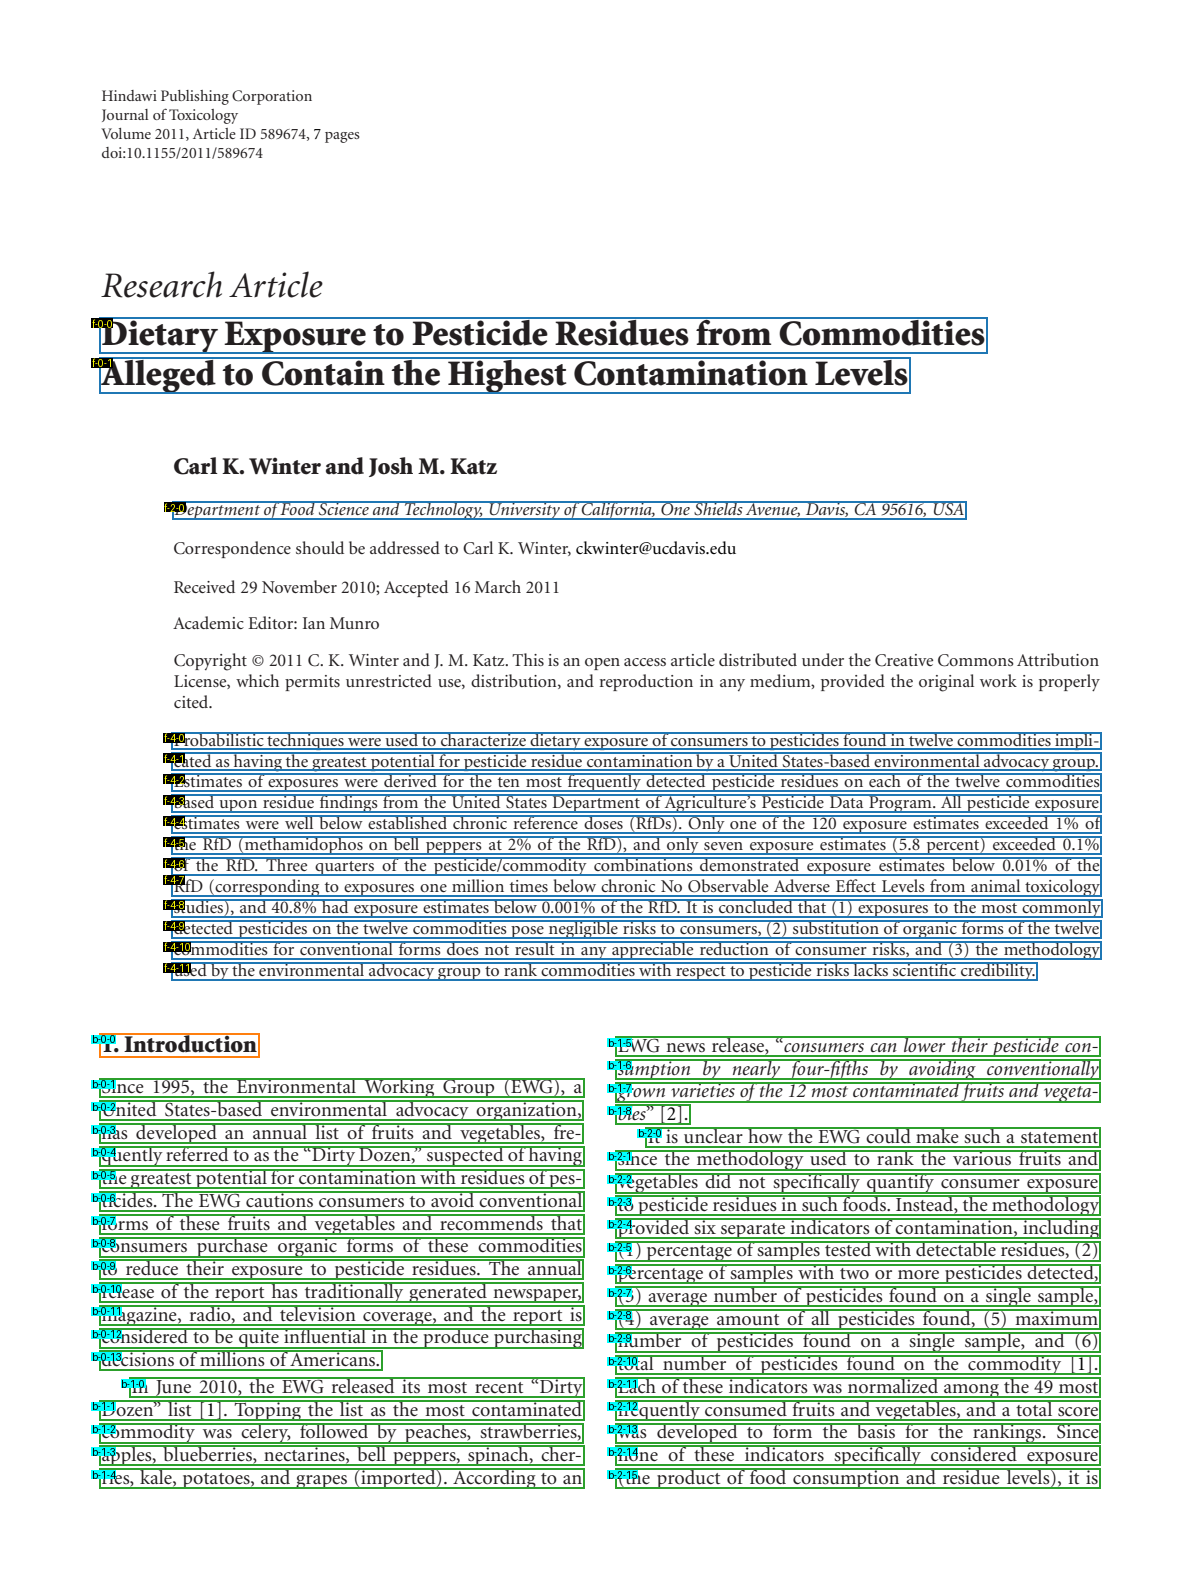

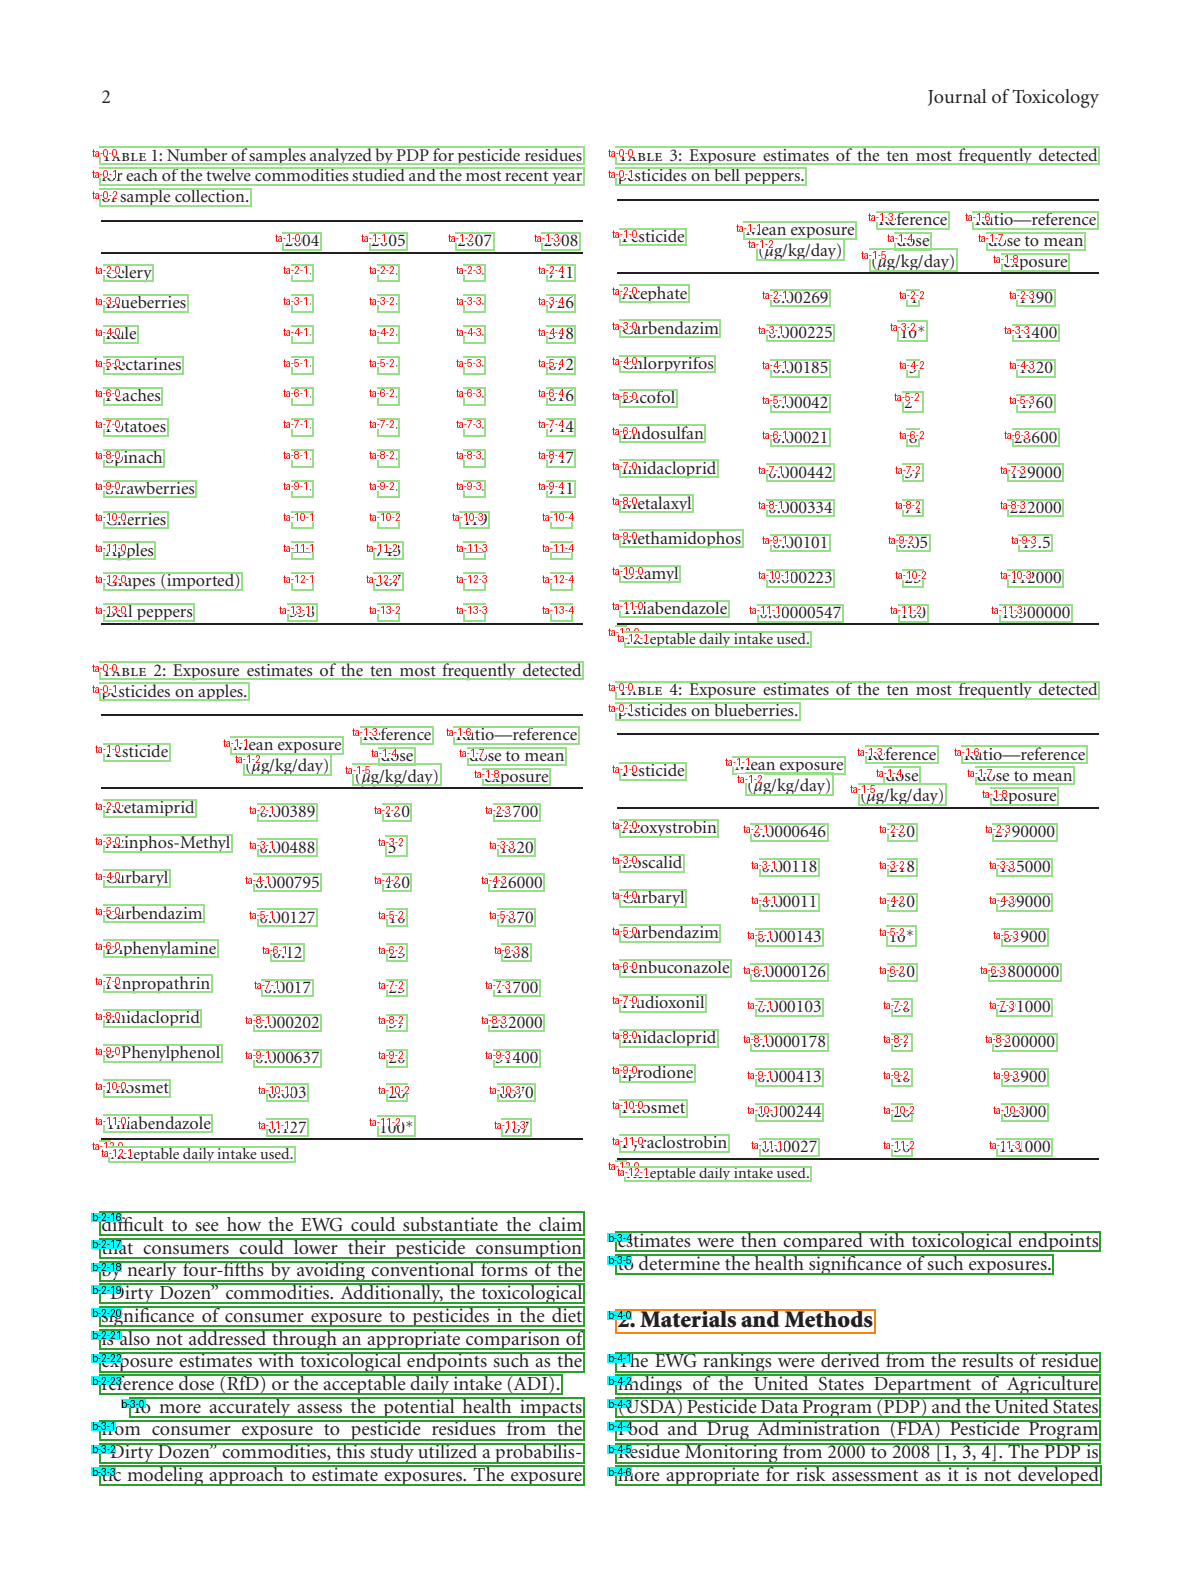

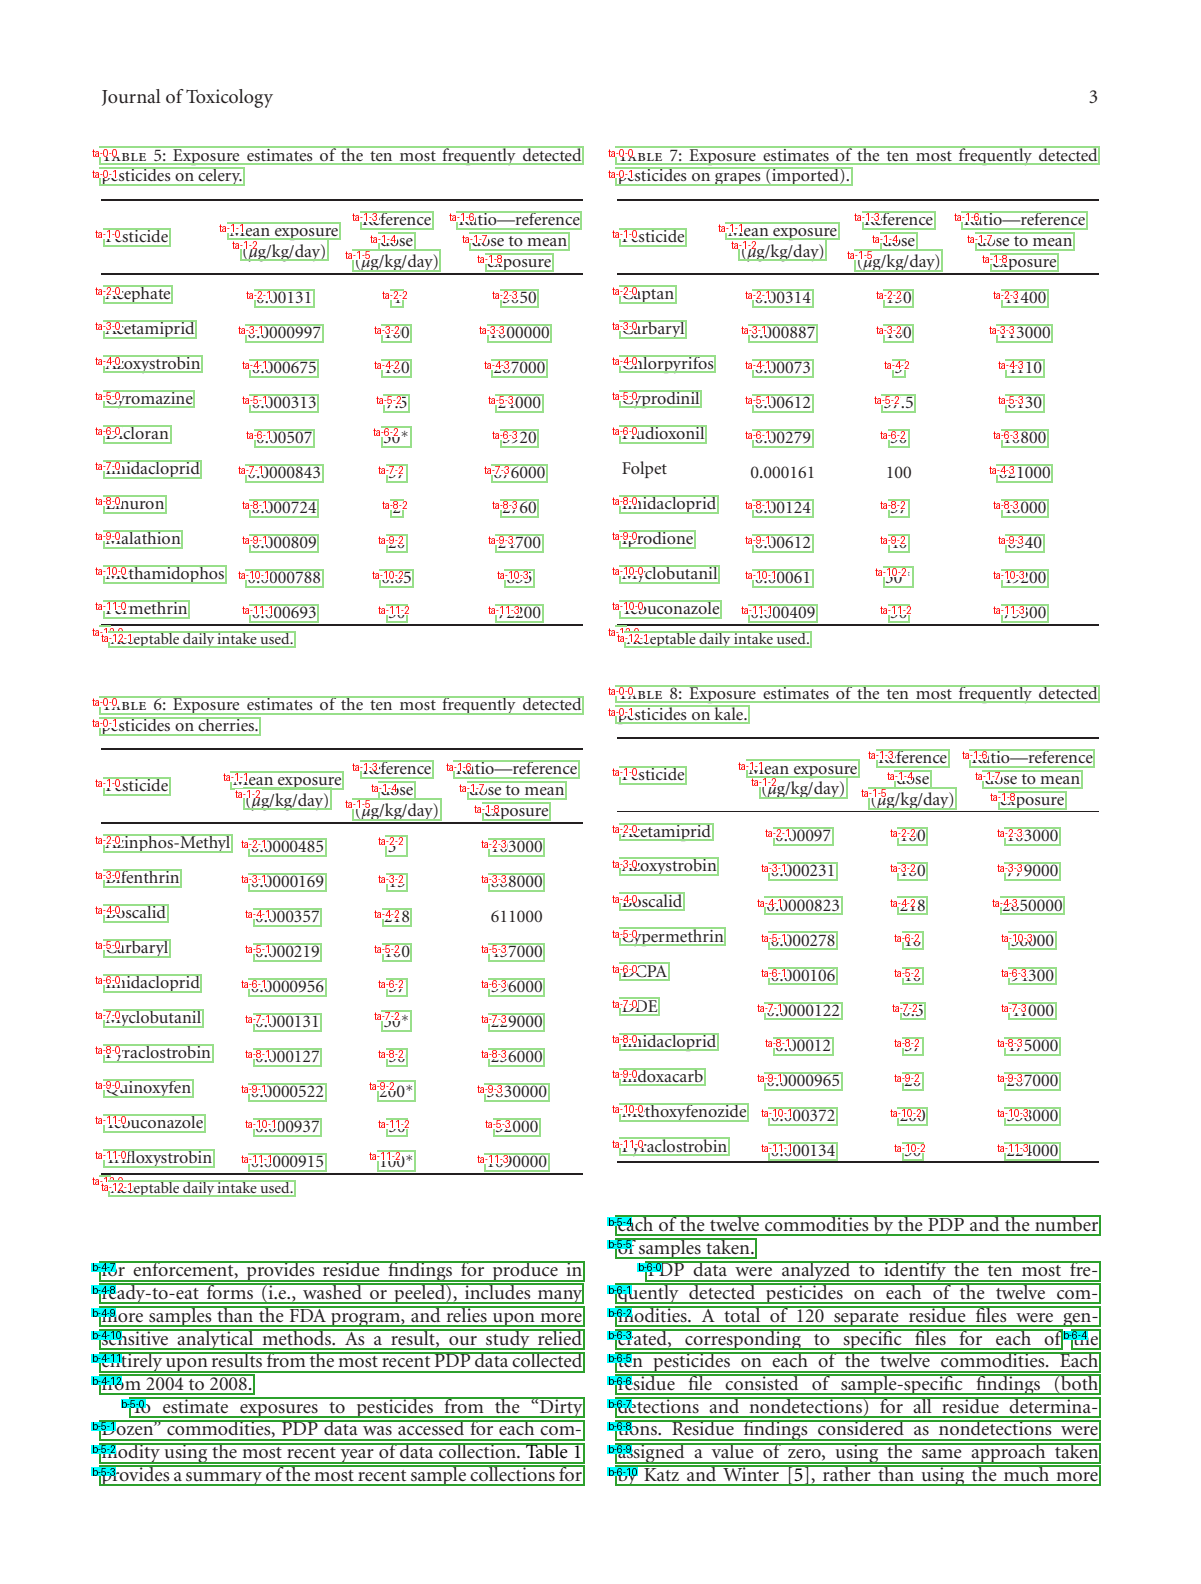

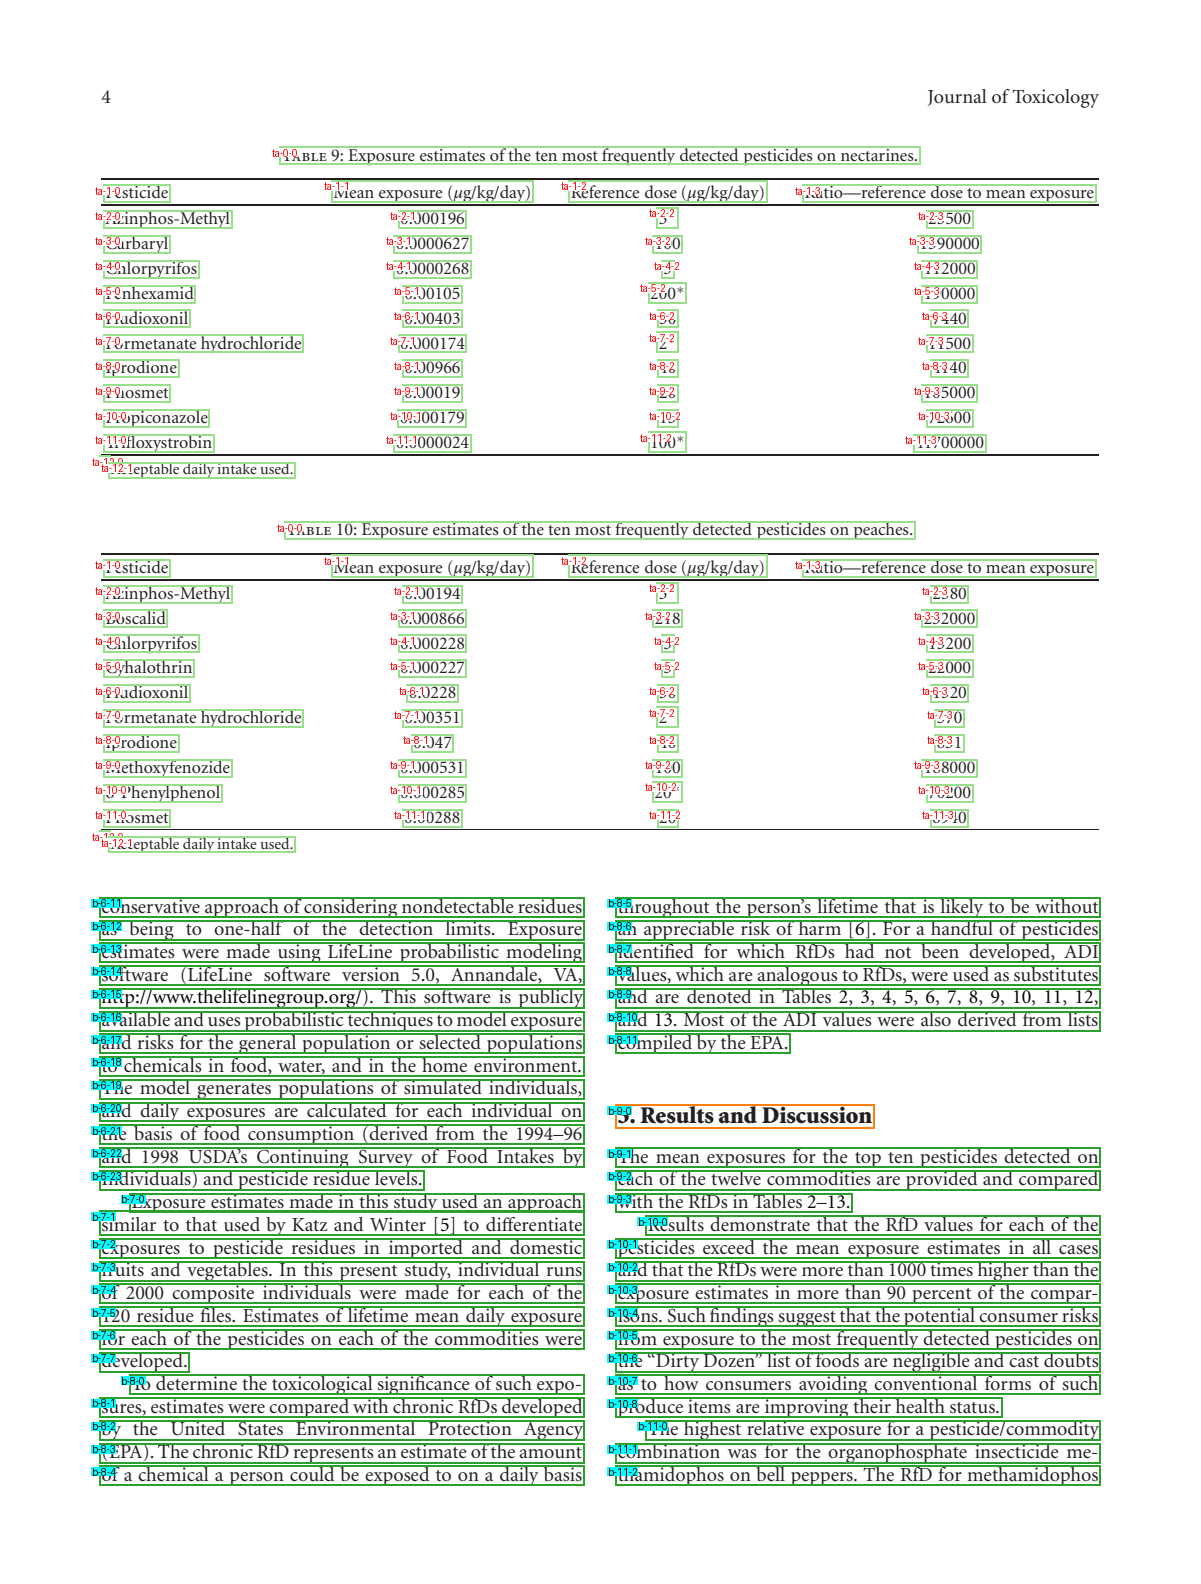

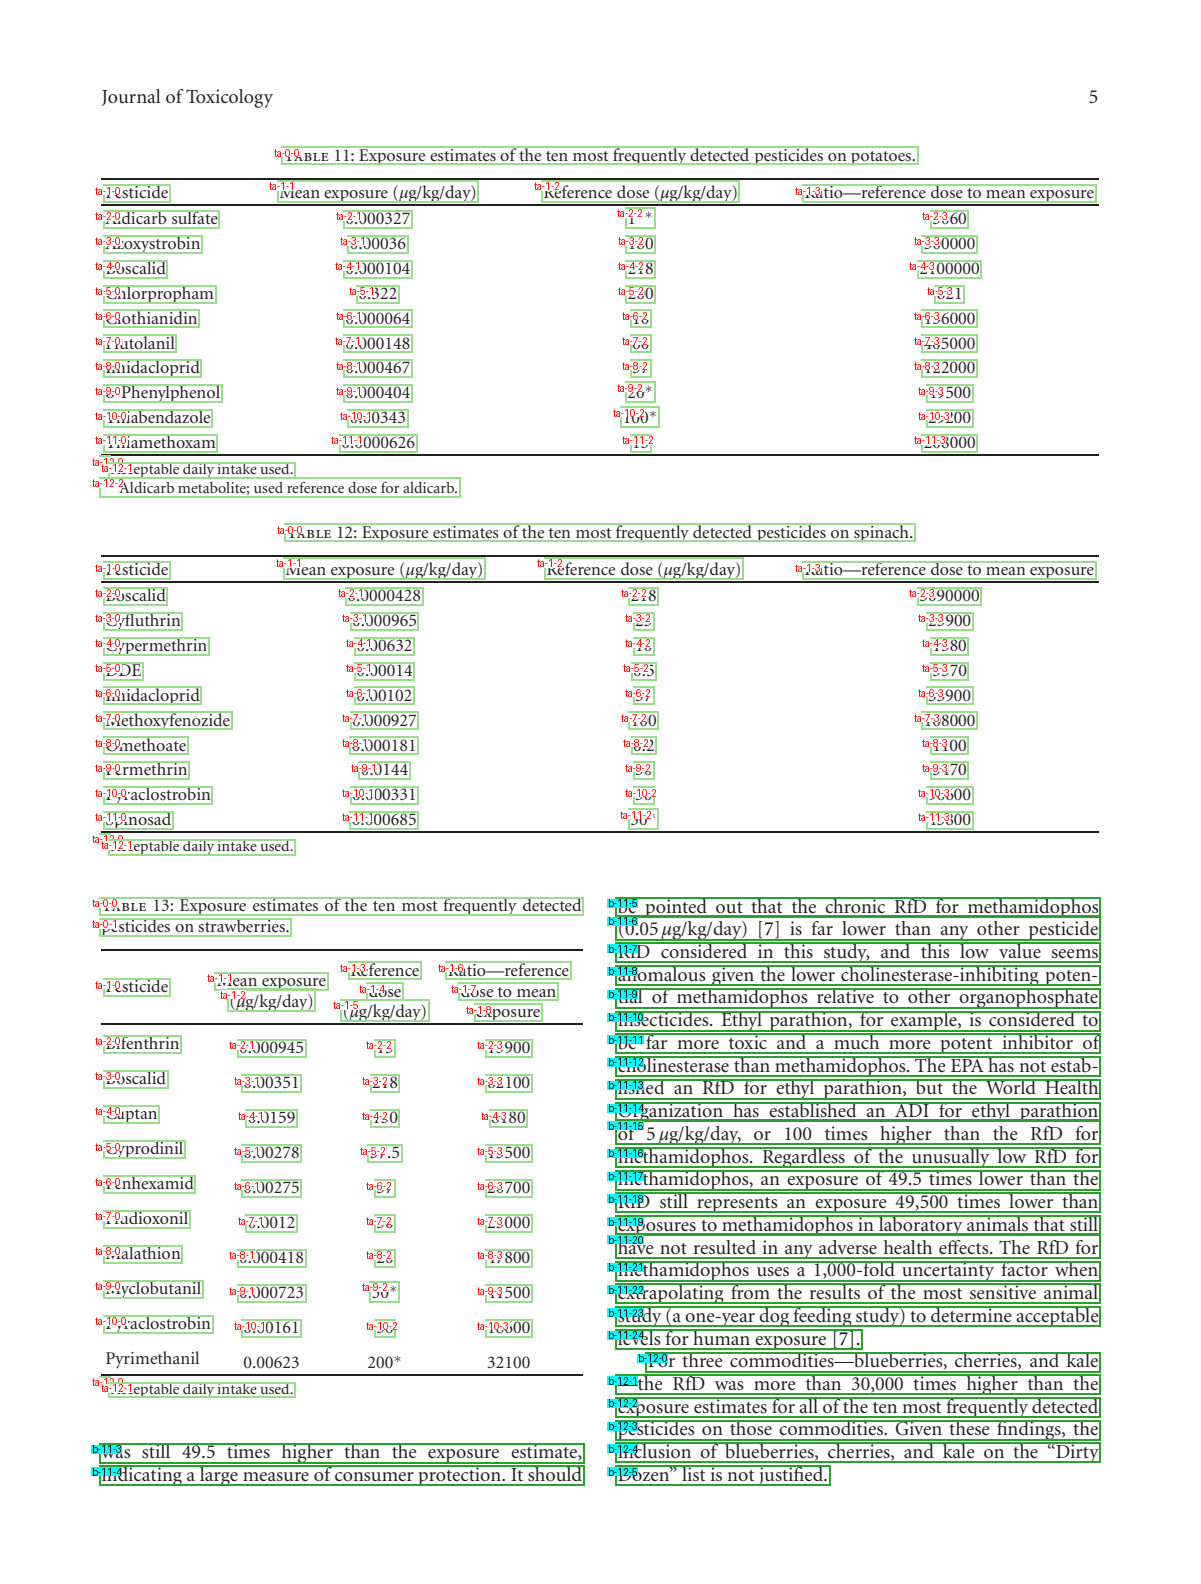

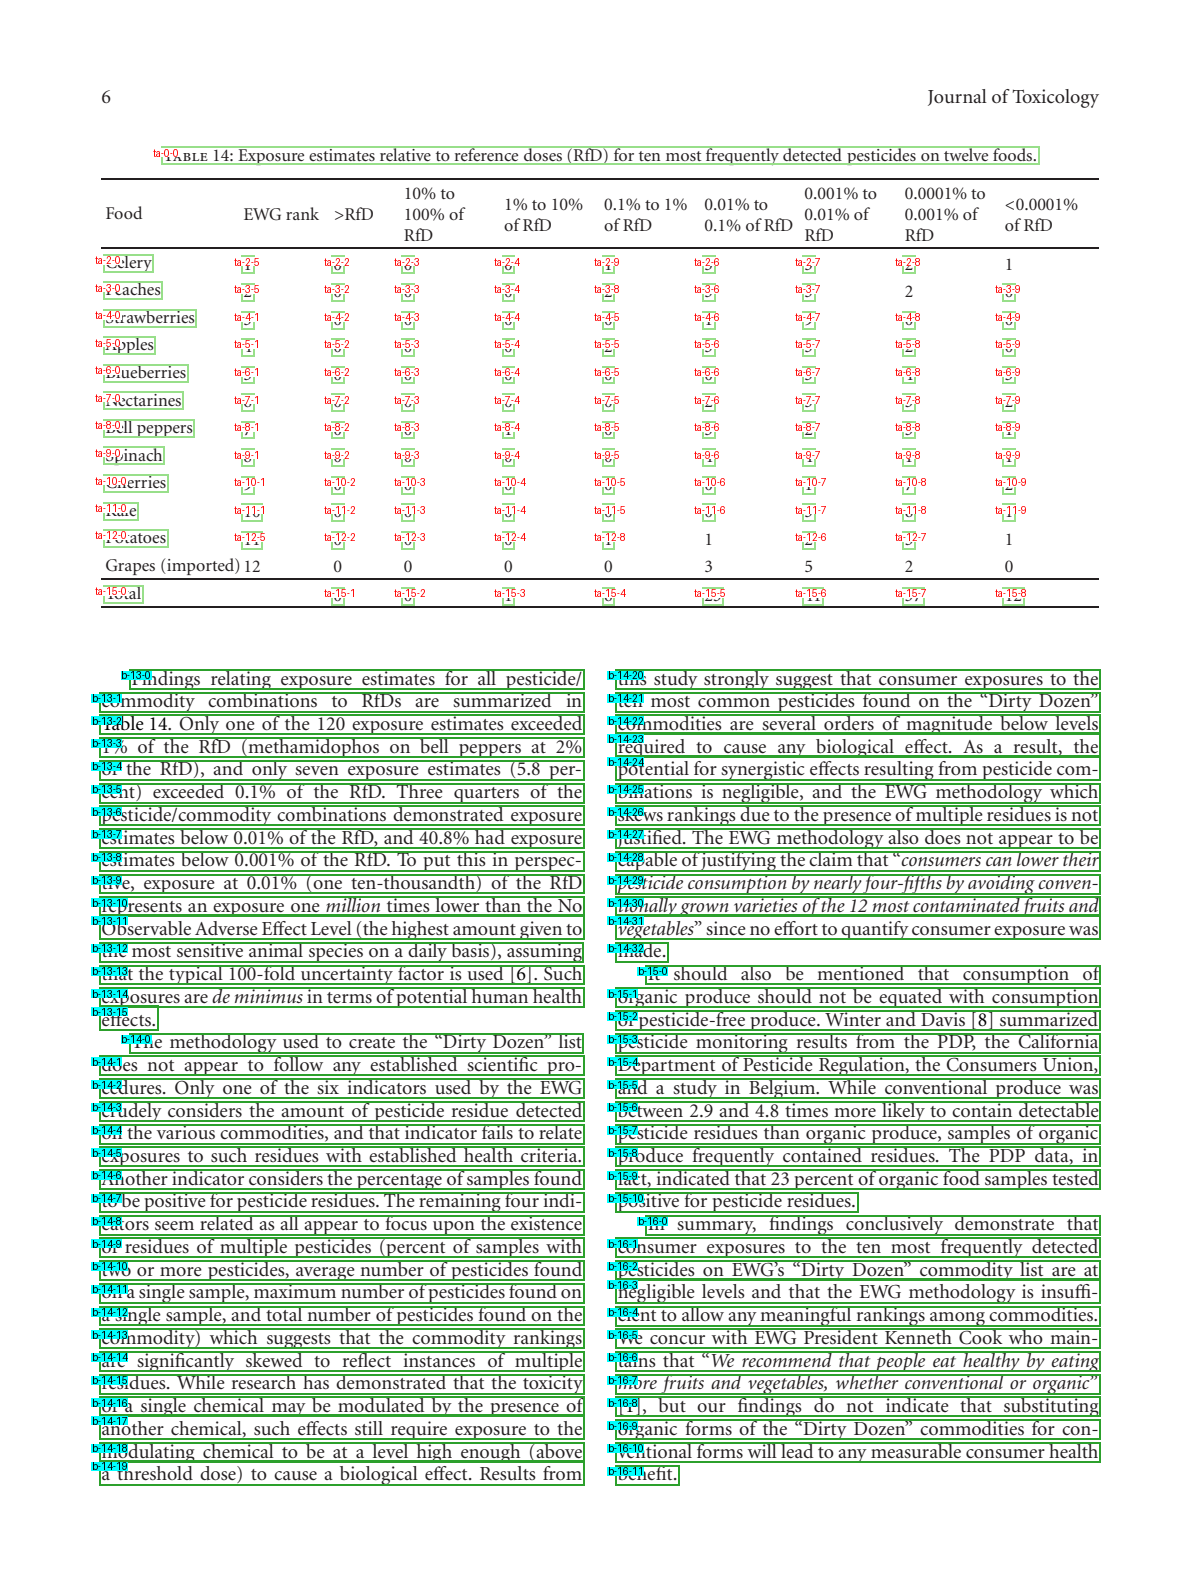

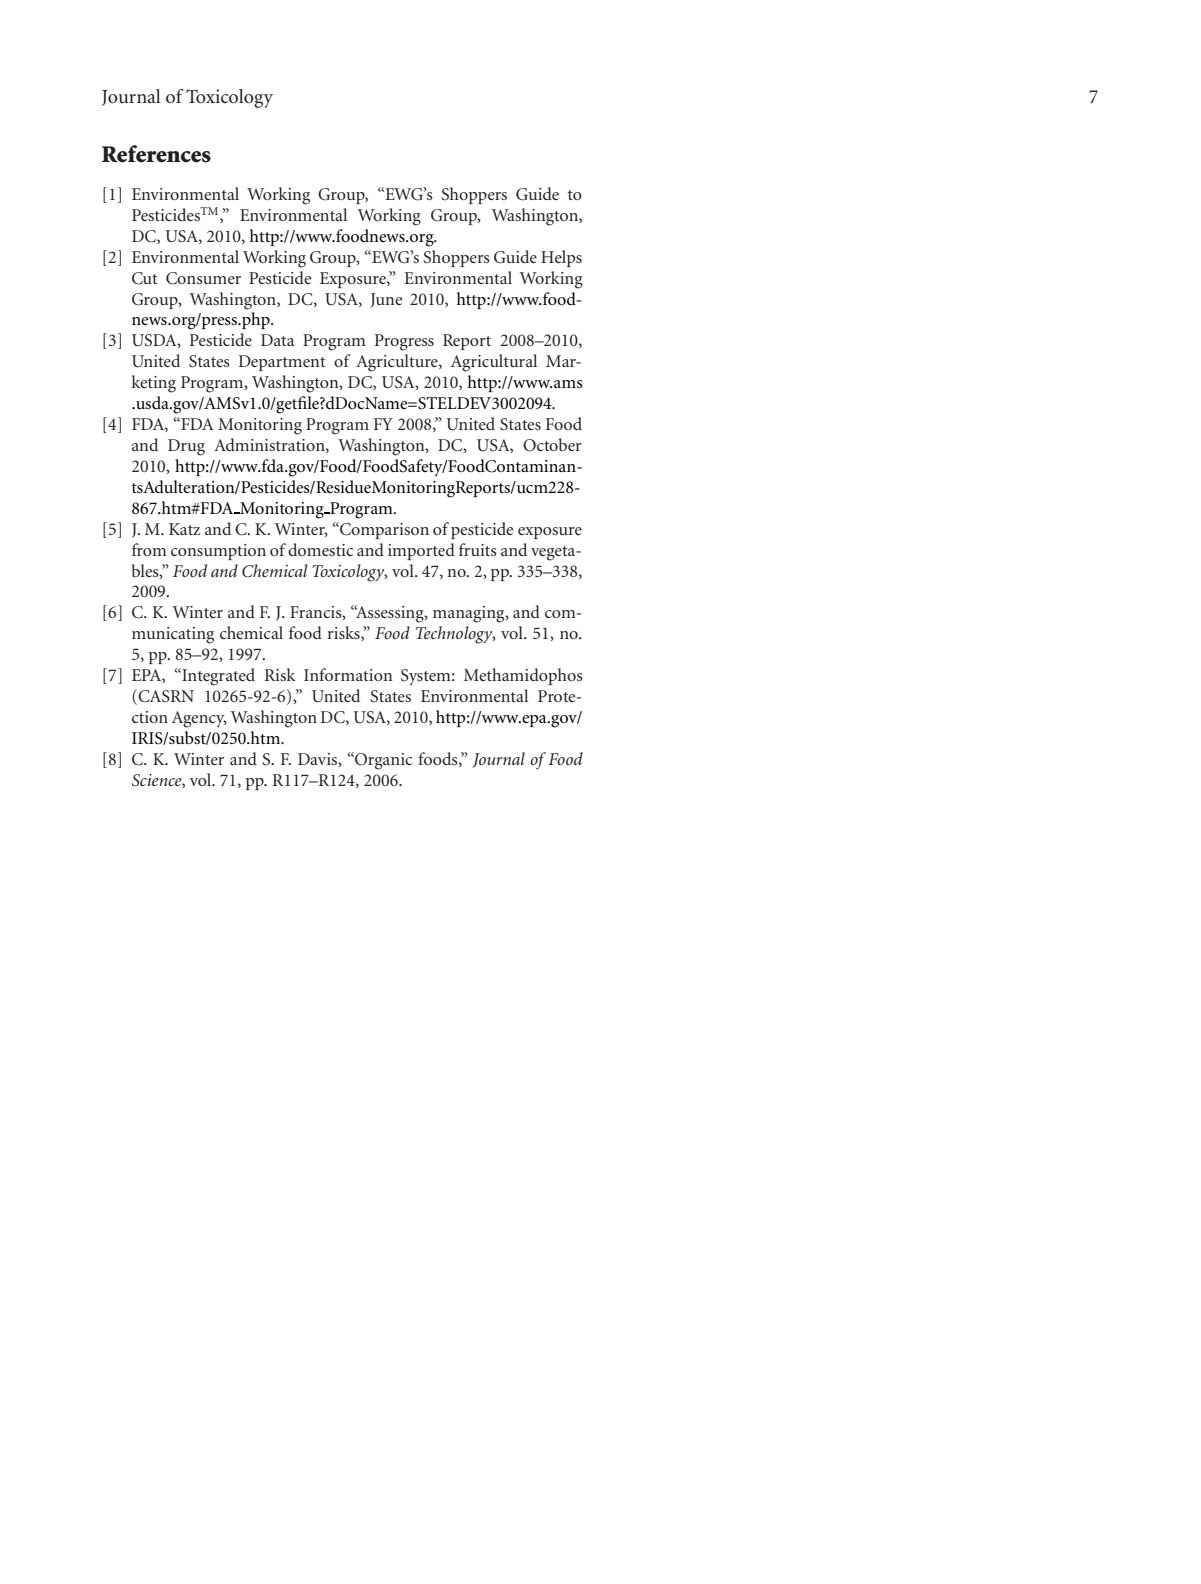

In [8]:
from edspdf.structures import Box, Box_lines, TextBox

pdf = Path(loaded_pmc_data['pdf_path']).read_bytes()
doc_2: PDFDoc = model.get_pipe("extractor")(pdf)

content_boxes = []
for li in loaded_pmc_data['front_lines'] + loaded_pmc_data['body_lines'] + loaded_pmc_data['table_lines']:
    _tb = TextBox(
        x0=li['x0'],
        x1=li['x1'],
        y0=li['y0'],
        y1=li['y1'],
        text=li['text'],
        label=li['label'],
        page_num=li['page_num'],
        )
    if li['node_type'] == 'front':
        _tb.rank = f"{li['node_type'][0]}-{li['node_num']}-{li['rank']}"
        _tb.color='yellow'
        _tb.bg_color='black'
    if li['node_type'] == 'body':
        _tb.rank = f"{li['node_type'][0]}-{li['node_num']}-{li['rank']}"
        _tb.color='black'
        _tb.bg_color='cyan'
    if li['node_type'] == 'table':
        _tb.rank = f"{li['node_type'][:2]}-{li['node_num']}-{li['rank']}"
        _tb.color='red'
        _tb.bg_color='white'
    content_boxes.append(_tb)

for page in show_annotations(doc_2.content, content_boxes):
    display(page)